# Lagrangian model for elastic-diffusive material #

In [37]:
from utilities import *
import os

# ----------------------------------------
# Set up and save model parameteres
# ----------------------------------------

fout = 'output_diffusion_elasticity_LAG+diff/'

if not os.path.exists(fout):
    os.makedirs(fout)

mu          = 4e-8
lmbda       = 0
biot        = 0.5                           # Biot's coefficient Comment: If we consider the compressibility to be of order 1 then this is the only parameter left to find
compr       = 2                           # Compressibility or Biot modulus
mob         = 1e-6                          # Diffusion coefficient 1e+5 with gamma = 0
kappa       = 5e-4                          # Darcy coefficient
g0          = 1.5                           # Gravitational accelleration
epsilon     = 1e-1                          # Logarithimic term coefficient
c0          = 0.01

# ----------------------------------------
# Parameters for mass density distribution
# ----------------------------------------
alpha       = 50                        # Controls radius of the fluid bubble
mag         = c0*0.2                       # Max porosity value
L           = 1e+4                      # 1 Km box size
z0          = 3600*9.81*L/(620*1e9)     # Rescaled rock gravity
gamma       = -10*z0                         #   -1/(mag)*z0

pars = {}
pars['mu']          = mu
pars['lmbda']       = lmbda
pars['biot']        = biot
pars['compr']       = compr
pars['mob']         = mob
pars['kappa']       = kappa
pars['g0']          = g0
pars['epsilon']     = epsilon
pars['c0']          = c0
pars['alpha']       = alpha
pars['z0']          = z0
pars['mag']         = mag
pars['gamma']       = gamma


write_dictionary(fout + 'parameters.json',pars)

In [38]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt 
import logging
from utils import *

parameters["form_compiler"]["quadrature_degree"] = 5

# ------------------------------------
# Lagrangian energy
# ------------------------------------

def energybar(ubar,cbar):

    xbar        = SpatialCoordinate(meshbar)
    I           = Identity(dim)
    Fbar        = I + grad(ubar)
    Cbar        = Fbar.T*Fbar
    Jbar        = det(Fbar)
    p           = (cbar-c0) - biot*(Jbar-1) # inner(abiot,Fs-I)   # Pressure/Coupling term

    g               = Expression(('0','g0'),g0=g0,degree=2)  # Gravity
    rho0            = Expression('z0',z0=z0,degree=3)

    Ebar        = mu/2*(tr(Cbar-I) - 2*ln(Jbar)) + lmbda/2*(Jbar-1)**2
    Egr         = inner(g*(rho0+gamma*cbar),xbar+ubar)
    Emix        = compr*p**2/2
    Echem       = epsilon*cbar*(ln(cbar) - 1)

    Etot = Ebar + Egr + Echem + Emix
    return Etot

# --------------------------------------
# Bilinear forms 
# --------------------------------------

def a(old_Fbar,cbar,eta_cbar,deta_cbar):
    return 0.5*mob*(cbar/c0)**2*inner(inv(old_Fbar).T*grad(eta_cbar), inv(old_Fbar).T*grad(deta_cbar)) 

def b(dot_cbar, deta_cbar):
    return inner(dot_cbar, deta_cbar)

def s(old_Fbar,dot_ubar,dubar):
    A           = inv(old_Fbar)
    old_Jbar    = det(old_Fbar)
    return 0.5*kappa*inner(sym(grad(dot_ubar)*A),sym(grad(dubar)*A))*old_Jbar

# ------------------------------------
# Solve Lagrangian problem
# ------------------------------------

def evolve_bar(old_qbar,tau):
    qbar  = Function(Qbar)     # unknown 
    dqbar = TestFunction(Qbar) # test function
    
    # current solution
    ubar, cbar, eta_cbar = split(qbar)
    # old solution
    old_ubar, old_cbar, old_eta_cbar = split(old_qbar)
    # test functions
    dubar, dcbar, deta_cbar = TestFunctions(Qbar)

    I           = Identity(dim)
    old_Fbar    = I + grad(old_ubar)
    old_Jbar    = det(old_Fbar)
    Fbar        = I + grad(ubar)

    Hbar     = energybar(ubar,cbar)*dx
    dot_ubar = (ubar - old_ubar)/tau
    dot_cbar = (cbar - old_cbar)

    Resbar          = b(eta_cbar, dcbar)*dx - derivative(Hbar,qbar,dqbar)
    Resbar         += -s(old_Fbar,dot_ubar,dubar)*dx
    Resbar         += b(dot_cbar, deta_cbar)*dx + tau*a(old_Fbar,cbar,eta_cbar,deta_cbar)*dx
    
    qbar.assign(old_qbar)
    solve(Resbar==0,qbar,bc,solver_parameters={'newton_solver': {'linear_solver': 'mumps'}})
    return qbar 

# ------------------------------------
# Creating proper initial data for the displacement
# ------------------------------------

def solve_initial_data(cbarinit):
    Qvec        = VectorElement('P',triangle, 1) # Function space for solid alpha
    Vtemp       = FunctionSpace(meshbar,Qvec)
    
    utemp,dutemp    = Function(Vtemp),TestFunction(Vtemp)

    I = Identity(dim)
    Ftemp = inv(I-grad(utemp))

    Etemp =  energybar(utemp, cbarinit)*dx 
    Etemp += inner(grad(utemp),grad(utemp))*dx
    
    # bc_bar = DirichletBC(Vtemp, Constant((0, 0)) , 'on_boundary')
    bc1             = DirichletBC(Vtemp, Constant((0, 0)), 'on_boundary && near(x[1],0,1e-3)')
    bc2             = DirichletBC(Vtemp.sub(0), Constant(0), 'on_boundary && (near(x[0],0,1e-3) || near(x[0],1,1e-3))')

    bc_bar = [bc1,bc2]

    Restemp =  derivative(Etemp,utemp,dutemp)  
    solve(Restemp==0, utemp, bc_bar,solver_parameters={"newton_solver":{"linear_solver"      : "mumps",
                                                    "absolute_tolerance" : 1e-7,
                                                    "maximum_iterations" : 30 }}) 
    return utemp

In [39]:
######################
# MAIN
######################
print("here we go")
pars    = read_dictionary(fout + 'parameters.json')

pars['mu']          = mu
pars['lmbda']       = lmbda
pars['biot']        = biot
pars['compr']       = compr
pars['mob']         = mob
pars['kappa']       = kappa
pars['g0']          = g0
pars['epsilon']     = epsilon
pars['c0']          = c0
pars['alpha']       = alpha
pars['z0']          = z0
pars['mag']         = mag
pars['gamma']       = gamma

rr          = 6
n_steps     = 10*4 * 2**rr
T           = 4000.0         # Final time
tau         = T/n_steps    # Time-step size
k           = 32          # mesh points

print('tau:',tau,' n_steps:',n_steps,' k:',k)

dim         = 2     # spatial dimension
FE_deg      = 1
FEu         = VectorElement('P',triangle, FE_deg)
FEc         = FiniteElement("CG", triangle, FE_deg) # Function space for concentration
FEmu        = FiniteElement("CG", triangle, FE_deg) # Function space for forces

# ------------------------------------
# Setup mesh, function space, BCs
# ------------------------------------

meshbar         = RectangleMesh(Point(0,0),Point(1,2),k,3*k,diagonal="left/right") # Generation of Lagrangian mesh
Qbar            = FunctionSpace(meshbar, MixedElement([FEu,FEc,FEmu]))

bc1             = DirichletBC(Qbar.sub(0), Constant((0, 0)) , 'on_boundary && near(x[1],0,1e-3)')
bc2             = DirichletBC(Qbar.sub(0).sub(0), Constant(0), 'on_boundary && (near(x[0],0,1e-3) || near(x[0],1,1e-3))')

bc              = [bc1,bc2]

# ----------------------------
# Set Up of Inital conditions
# ----------------------------
# initialbar = Expression(("0", "0",                                                      # Displacement
#                         '1+mag*exp(-alpha*((pow(x[0]-0.5,2))+(pow(x[1]-0.5,2))))',      # Concentration
#                         "0"),                                                           # Concentration_force
#                         degree=4, t=0.0,alpha=alpha,mag=mag)

cbarexp = Expression('c0+mag*exp(-alpha*((pow(x[0]-0.5,2))+(pow(x[1]-0.5,2))))',degree=4, t=0.0,c0=c0,alpha=alpha,mag=mag)
cbarinit = project(cbarexp,FunctionSpace(meshbar,'CG',1))
print('prepare initial data')
ubar_init = solve_initial_data(cbarinit)
print('done')
    
old_qbar = Function(Qbar)
assign(old_qbar.sub(0),ubar_init)
assign(old_qbar.sub(1),project(cbarinit,FunctionSpace(meshbar,'CG',1)))

# old_qbar = interpolate(initialbar,Qbar)

# ---------------------------------
# Perform smaller initial time step
# ---------------------------------
t        = 0.0
dt0      = 1e-4
qbar = evolve_bar(old_qbar,dt0)
old_qbar.assign(qbar)

write_state(meshbar,old_qbar,fout+'statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(0),0,t)
for i in range(n_steps):
    print("0:",i)
    qbar = evolve_bar(old_qbar,tau)
    old_qbar.assign(qbar)
    t += tau
    write_state(meshbar,old_qbar,fout+'statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i+1),i+1,t)

here we go
tau: 1.5625  n_steps: 2560  k: 32
prepare initial data
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 9.841e-05 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 7.043e-09 (tol = 1.000e-07) r (rel) = 7.157e-05 (tol = 1.000e-09)
        Newton solver finished in 1 iterations and 1 linear solver iterations.
done
      No Jacobian form specified for nonlinear variational problem.
      Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
      Solving nonlinear variational problem.
        Newton iteration 0: r (abs) = 1.762e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
        Newton iteration 1: r (abs) = 3.119e-09 (t

      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.
      Object cannot be plotted directly, projecting to piecewise linears.


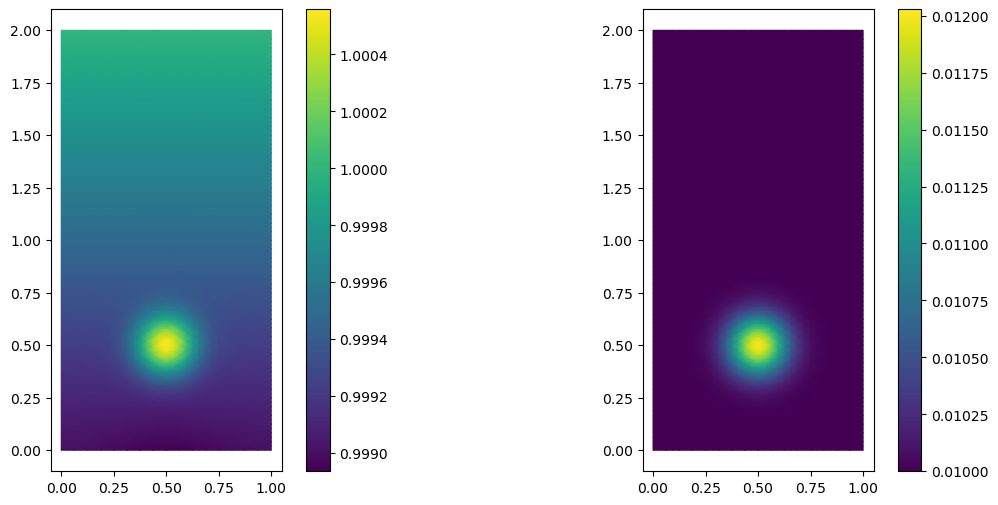

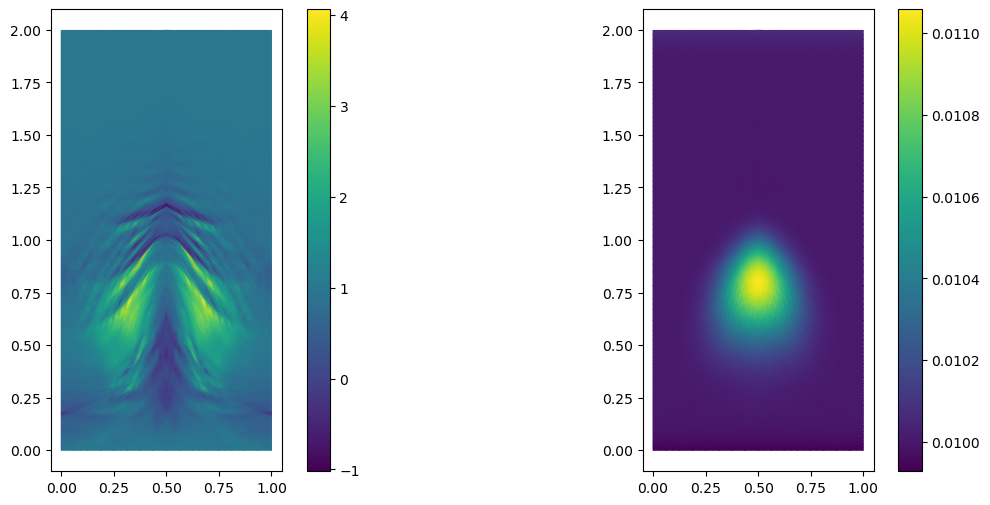

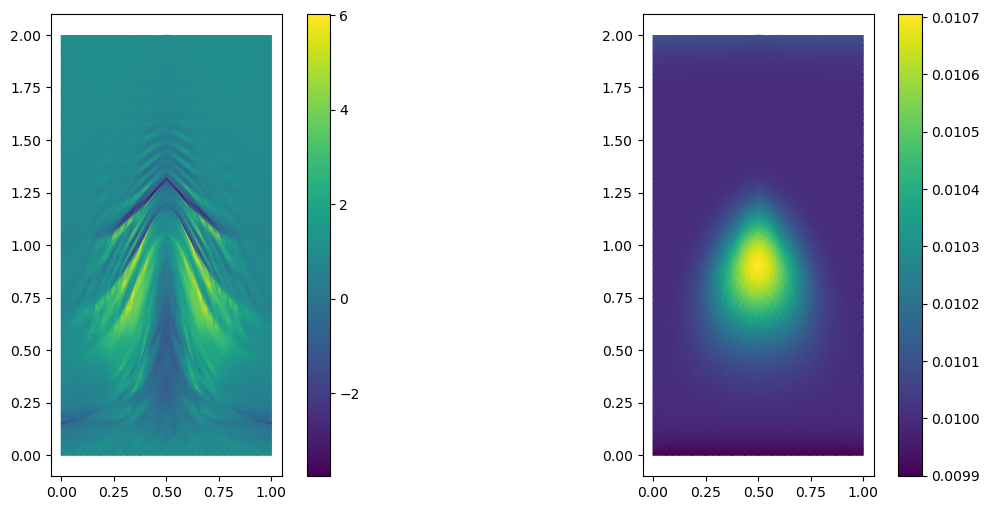

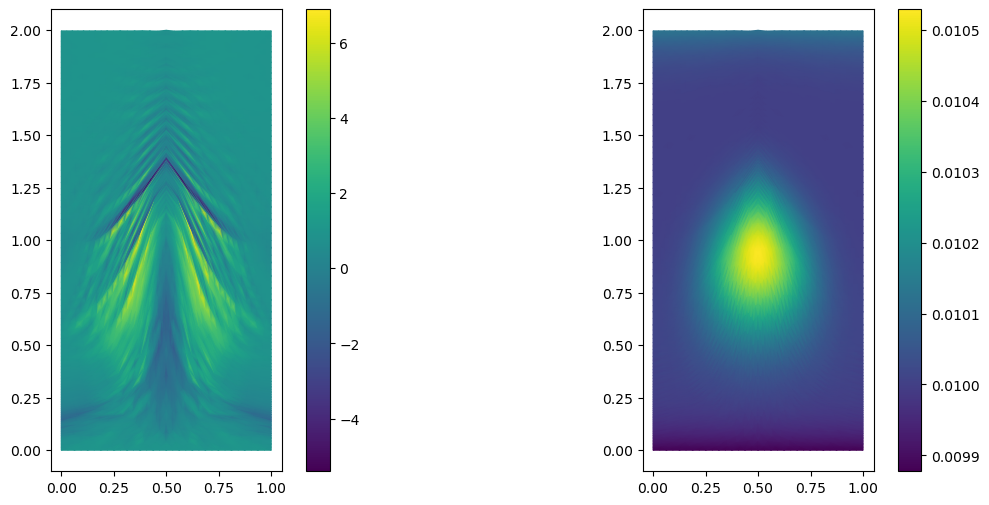

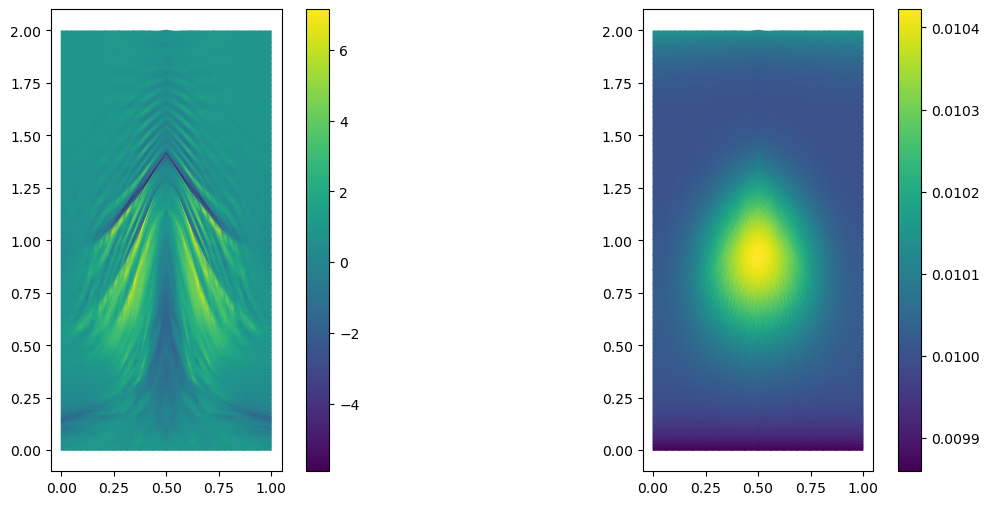

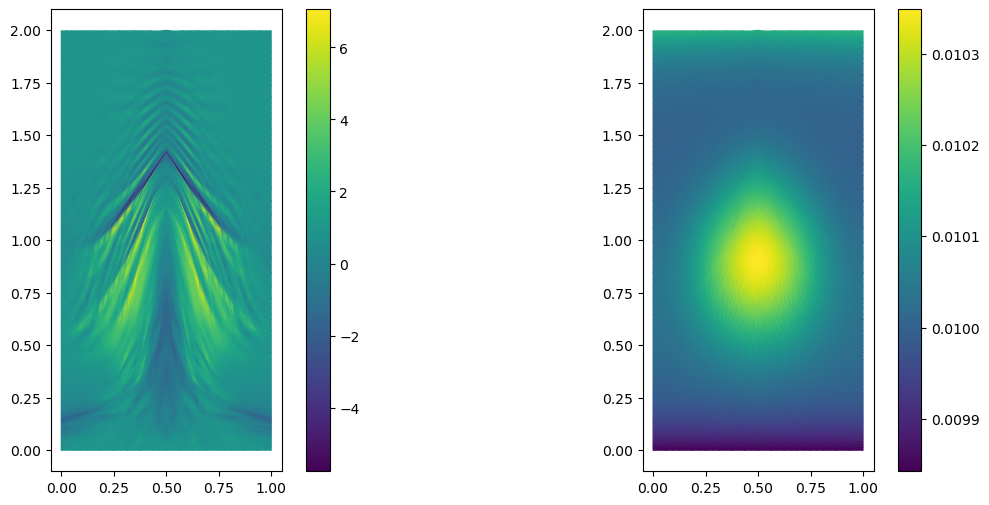

In [40]:
from utils import *
from fenics import *
from mshr import *
import numpy as np
from pylab import plt
import os

fout = 'output_diffusion_elasticity_LAG+diff/'

mesh_list   = []
u_list      = [] 
J_list      = []   
c_list      = []
eta_list    = []
F_list      = []
dim         = 2
FE_deg      = 1
FEu         = VectorElement('P',triangle,FE_deg)
FEc         = FiniteElement("CG", triangle, FE_deg) # Function space for concentration
FEmu        = FiniteElement("CG", triangle, FE_deg) # Function space for forces
FE          = MixedElement([FEu,FEc,FEmu])
j           = [0,500,1000,1500,2000,2559]

for i in j:
    mesh,q,it,t = read_state(fout+'statebarP1_'+str(k)+'_'+str(n_steps)+'_'+str(i),FE)
    mesh_list.append(mesh)
    u,c,eta     = split(q)
    u_list.append(u)      
    xbar = SpatialCoordinate(mesh)
    I    = Identity(dim)
    Fbar = I + grad(u)
    Cbar = Fbar.T*Fbar
    Jbar = det(Fbar)
    J_list.append(Jbar)
    c_list.append(c)
    F_list.append(Fbar)
    
for i in range(len(j)):
    u = project(u_list[i],VectorFunctionSpace(mesh_list[i],'CG',1))
    ALE.move(mesh_list[i],u)
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    gph1 = plot(J_list[i],mode='color')
    plt.colorbar(gph1)
    plt.subplot(1,2,2)
    gph2 = plot(c_list[i],mode='color')
    plt.colorbar(gph2)
    # if i>0:
    #     plt.subplot(1,3,3)
    #     cdiff = project(c_list[i]-c_list[i-1],FunctionSpace(mesh_list[i],'CG',1))
    #     gph3 = plot(cdiff,mode='color')
    #     plt.colorbar(gph3)
    # if i == len(j)-1:
    plt.savefig('media/Lagrangian+species' +str(i)+ '.png',dpi=300,bbox_inches = 'tight')
